# Notebook #2: Surrogates for steam tables (PHT) with Hyperplane Trees

This notebook is part of the Supporting Information of the paper "Hyperplane Decision Trees as Piecewise Linear Surrogate Models for Chemical Process Design", by Sunshine et al.

This file shows a case study for the use of the [hyperplanetree](https://github.com/LLNL/systems2atoms/tree/add-hyperplanetree/systems2atoms/hyperplanetree) Python package.

We show the steps to train a surrogate model using the package, besides hyperparameter sweep for the main hyperparameter and performance comparisons to other decision tree-based models. 

Physical data as used by [Ammari et al](https://www.sciencedirect.com/science/article/pii/S009813542300217X), obtained through [IDAES](https://idaes.org/). 

Contact the authors of the paper if you have any questions.

## Installing the package from github

In [ ]:
!pip install git+https://github.com/LLNL/systems2atoms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from systems2atoms.hyperplanetree import LinearTreeRegressor, HyperplaneTreeRegressor, plot_surrogate_2d
import torch 
import sklearn
import time
from tqdm.auto import tqdm
from IPython.display import display, HTML
import base64
import io
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import lineartree
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches
from sklearn.metrics import mean_absolute_error
from iapws import IAPWS97


plt.rcParams['figure.dpi'] = 200
torch_device = 'cpu' 

## Preparing the data for use in the regression

In [3]:
df = pd.read_csv('PHTSV_Table_HMAX_Adjusted.csv', usecols=[0, 1, 2])

df

,P(Pa),H(J/mol),T(K)
0,1.000000e+05,1275.88638,290.000000
1,3.515152e+05,1275.88638,289.942853
2,6.030303e+05,1275.88638,289.885698
3,8.545455e+05,1275.88638,289.828536
4,1.106061e+06,1275.88638,289.771366
...,...,...,...
9995,2.399394e+07,65523.00000,920.211096
9996,2.424545e+07,65523.00000,920.898379
9997,2.449697e+07,65523.00000,921.583218
9998,2.474848e+07,65523.00000,922.265623


In [5]:
# Features will be the first two columns, pressure and enthalpy data
features = torch.tensor(df[['P(Pa)', 'H(J/mol)']].values, dtype=torch.float64)

# Response will be the third and last column, of temperature
y = torch.tensor(df['T(K)'].values, dtype=torch.float64)

features[:, 0] = features[:, 0] / 1e5  # Convert pressure from Pa to bar for consistency with plot in Ammari (20223)
features[:, 1] = features[:, 1]  / 1000  # Convert enthalpy from J/mol to kJ/mol 

pressure = features[:, 0]
enthalpy = features[:, 1]
temperature = df['T(K)']

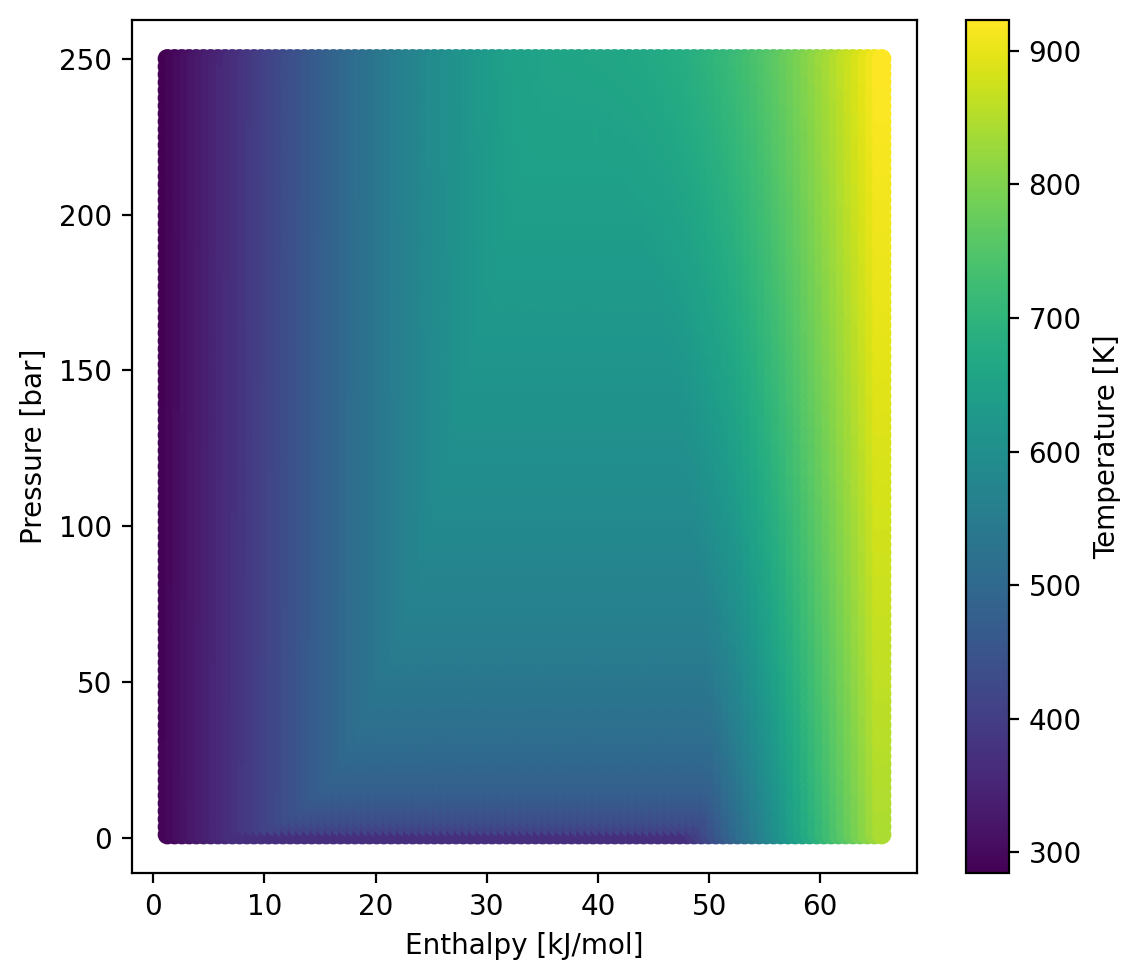

<Figure size 1280x960 with 0 Axes>

In [6]:
# Plotting the original data
fig = plt.figure(figsize=(11,5))

# 2D plot (Left side)
ax1 = fig.add_subplot(121) 
sc1 = ax1.scatter(enthalpy, pressure, c=temperature, cmap='viridis')
cbar1 = fig.colorbar(sc1, ax=ax1)
cbar1.set_label('Temperature [K]')
ax1.set_xlabel('Enthalpy [kJ/mol]')
ax1.set_ylabel('Pressure [bar]')

plt.tight_layout()
plt.show()

# 3D plot (Right side)
ax2 = fig.add_subplot(122, projection='3d') 
sc2 = ax2.scatter(pressure, enthalpy, temperature, c=temperature, cmap='viridis')
cbar2 = fig.colorbar(sc2, ax=ax2)
cbar2.set_label('Temperature [K]')
ax2.set_xlabel('Enthalpy [kJ/mol]')
ax2.set_ylabel('Pressure [bar]')
# ax2.set_zlabel('Temperature [K]')

# Change the viewing angle here (adjust elev and azim)
ax2.view_init(elev=20, azim=-60)

plt.tight_layout()
plt.show();

### Getting train and test splits

Here, we use the splitting feature in [scikit-learn](https://scikit-learn.org/stable/). Alternative splitting methodologies can be used as well.

In [7]:
indices = np.arange(len(features))

# 20% of the data will be used for test, and 42 is used as the seed for random state, for reproducibility
train_features, test_features, train_y, test_y, train_indices, test_indices= train_test_split(features, y, indices, test_size=0.2, random_state=42)

# Making sure we have shuffled indices and correct splits
print(f'Train indices: {train_indices} ({np.size(train_indices)} points)')
print(f'Test indices: {test_indices} ({np.size(test_indices)} points)')

Train indices: [9254 1561 1670 ... 5390  860 7270] (8000 points)
Test indices: [6252 4684 1731 ... 7853 1095 6929] (2000 points)


## Training different types of decision tree models

### Traditional decision trees

The first model we will train is a traditional decision tree using the [scikit-learn](https://scikit-learn.org/stable/), in which each leaf corresponds to a constant value. 

In [8]:
# Grid search to find the best hyperparameters for the decision tree
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'ccp_alpha': [0.01, 0.05, 0.1, 0.2]
}

grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    # verbose=2
)

grid_search.fit(train_features, train_y)

best_model = grid_search.best_estimator_
print(f"best parameters in the search search: {grid_search.best_params_}")

# Evaluating the best model
train_predictions = best_model.predict(train_features)
test_predictions = best_model.predict(test_features)

train_mae = mean_absolute_error(train_y, train_predictions)
test_mae = mean_absolute_error(test_y, test_predictions)

print(f"Constrained Train MAE: {train_mae:.3f}")
print(f"Constrained Test MAE: {test_mae:.3f}")

# Final number of leaves and depth of the best model
num_leaves = best_model.get_n_leaves()
tree_depth = best_model.get_depth()

print(f"Number of leaves in the constrained best model: {num_leaves}")
print(f"Depth of the constrained best model: {tree_depth}")


best parameters in the search search: {'ccp_alpha': 0.01, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10}
Constrained Train MAE: 1.438
Constrained Test MAE: 1.961
Number of leaves in the constrained best model: 469
Depth of the constrained best model: 15


In [9]:
model_dt = DecisionTreeRegressor(random_state=42, **grid_search.best_params_)

t1 = time.time()
model_dt.fit(train_features, train_y)
t2 = time.time()

y_pred = model_dt.predict(test_features)

dt_error = mean_absolute_error(y_pred, test_y)

num_leaves_dt = model_dt.get_n_leaves()
dt_time = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Decision Tree:          {num_leaves_dt}          {dt_error:.3f}          {dt_time:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Decision Tree:          469          1.961          0.01


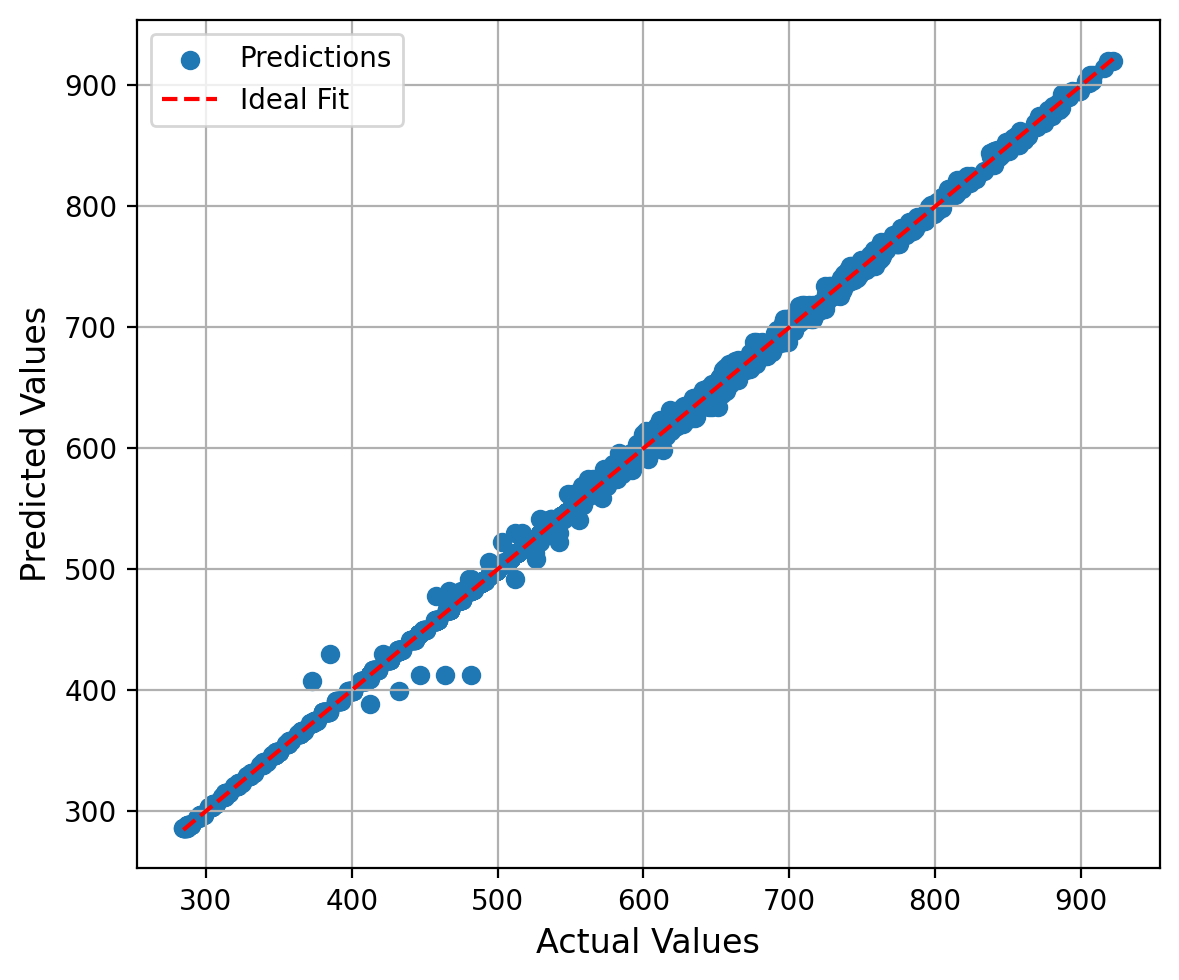

In [10]:
# Predicted vs Actual for the best traditional decision tree
y_pred = model_dt.predict(test_features)
y_actual = test_y

# Create the parity plot
plt.figure(figsize=(6,5))
plt.scatter(y_actual, y_pred, label='Predictions')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', label='Ideal Fit')
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Linear Tree Regressor by [Cerliani, 2022](https://github.com/cerlymarco/linear-tree)

The second model is a Linear Model Decision Tree (LMDT), as developed by Cerliani. Now, each leaf corresponds to a linear model of the form y = ax + b.

We will start by using the default hyperparameters:

In [11]:
import lineartree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model_cerliani = lineartree.LinearTreeRegressor(LinearRegression(), criterion="mae", min_samples_leaf=10, max_depth=10)

t1 = time.time()
model_cerliani.fit(train_features, train_y)
t2 = time.time()

# For evaluation, we will only use test data
y_pred = model_cerliani.predict(test_features)

mae = mean_absolute_error(test_y, y_pred)

print(f"MAE: {mae:.4f}")

Current number of nodes: 377 | Current number of leaves: 378
MAE: 0.5074


### Linear Tree Regressor in the hyperplanetree package

Now we will again train a Linear Model Decision Tree, this time as implemented in the package we are presenting. Note that in our implementation it is not necessary to use the LinearRegression() function from scikit-learn.

The first run will be with the default hyperparameters.

In [12]:
from systems2atoms.hyperplanetree import LinearTreeRegressor, HyperplaneTreeRegressor, plot_surrogate_2d

model_lt = LinearTreeRegressor()

t1 = time.time()
model_lt.fit(train_features, train_y)
t2 = time.time()

# For evaluation, we will only use test data
y_pred = model_lt.predict(test_features.to(torch_device)).cpu()

linear_error = torch.mean(torch.abs(y_pred - test_y))
linear_leaves = model_lt.num_leaves
linear_time = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Linear Tree:           {linear_leaves}            {linear_error:.3f}          {linear_time:.2f}')

  0%|          | 0/200.0 [00:00<?, ?it/s]

Model                  # Leaves      Error (MAE)    Training time (s)
Linear Tree:           71            1.025          0.59


Hyperparameter sweep - `min_samples_leaf`

In [13]:
min_samples_leaf_vals = np.logspace(-4, -0.5, 10)
numbers_of_leaves = []
train_errors = []
test_errors = []

for min_samples_leaf in tqdm(min_samples_leaf_vals):
    model = LinearTreeRegressor(
        min_samples_leaf = min_samples_leaf,
        disable_tqdm = True,
    )

    model.fit(train_features, train_y)
    
    numbers_of_leaves.append(model.num_leaves)

    y_pred = model.predict(features.to(torch_device)).cpu()

    train_errors.append(torch.mean(torch.abs(y_pred[train_indices] - y[train_indices])))
    test_errors.append(torch.mean(torch.abs(y_pred[test_indices] - y[test_indices])))

  0%|          | 0/10 [00:00<?, ?it/s]

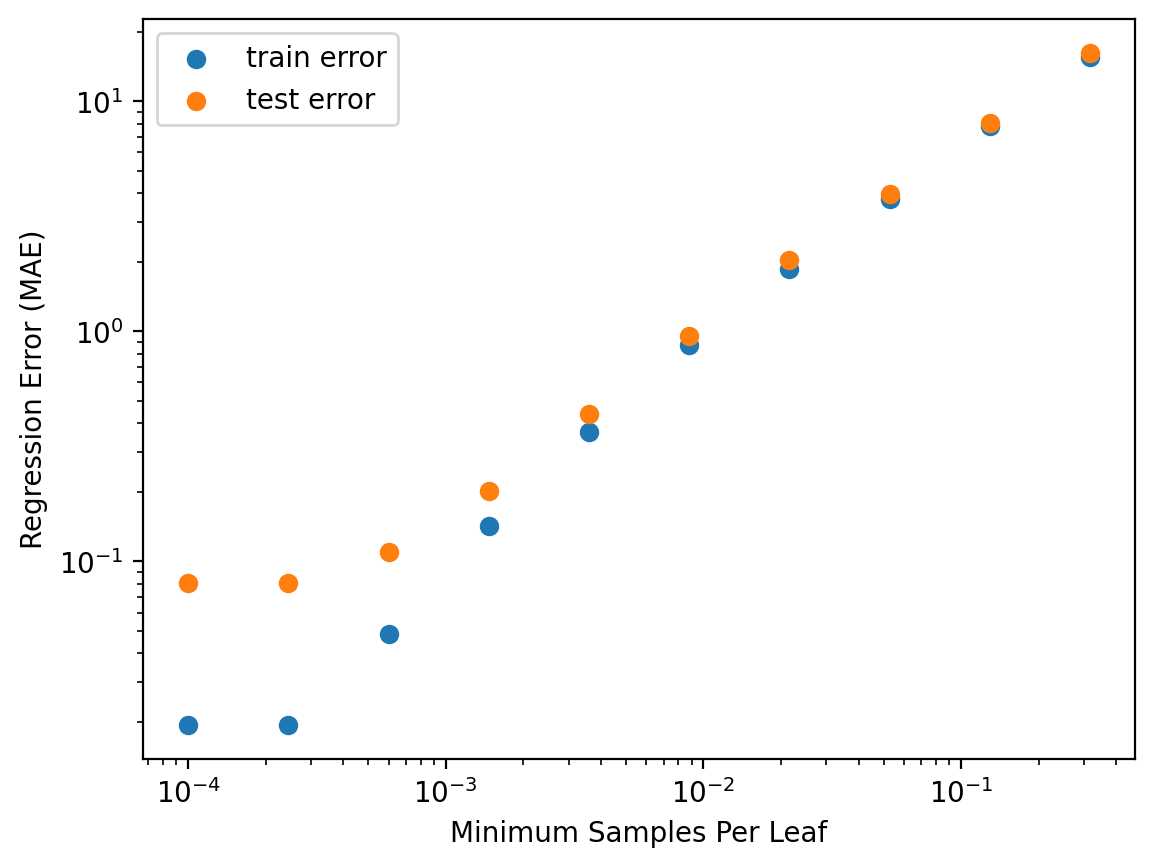

In [14]:
plt.scatter(min_samples_leaf_vals, train_errors, label = 'train error')
plt.scatter(min_samples_leaf_vals, test_errors, label = 'test error')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel('Minimum Samples Per Leaf')
plt.ylabel('Regression Error (MAE)')

plt.legend()

plt.show()

From the plot above, one can see that `min_samples_leaf` ~ 0.003 results in a low MAE while still not overfitting. 

This value means each leaf will have at least 0.3% of the data.

### Evaluation after hyperparameter sweep

In [15]:
model_ltr = LinearTreeRegressor(
    min_samples_leaf=0.004,
    disable_tqdm = True,
)
                        
t1 = time.time()
model_ltr.fit(train_features, train_y) 
t2 = time.time()

# Getting predictions around the test set usinf the model just fitted
y_pred_ltr = model_ltr.predict(test_features.to(torch_device)).cpu() 

# Assessing the mean absolute error 
linear_error = torch.mean(torch.abs(y_pred_ltr - test_y)) 

linear_leaves = model_ltr.num_leaves
linear_time = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Linear Tree:           {linear_leaves}            {linear_error:.3f}          {linear_time:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Linear Tree:           181            0.521          0.51


See the documentation for more hyperparameters and descriptions (uncomment the cell below):

In [16]:
# print(LinearTreeRegressor.__doc__)

Visualizing the splits - a feature of the HyperplaneTree package:

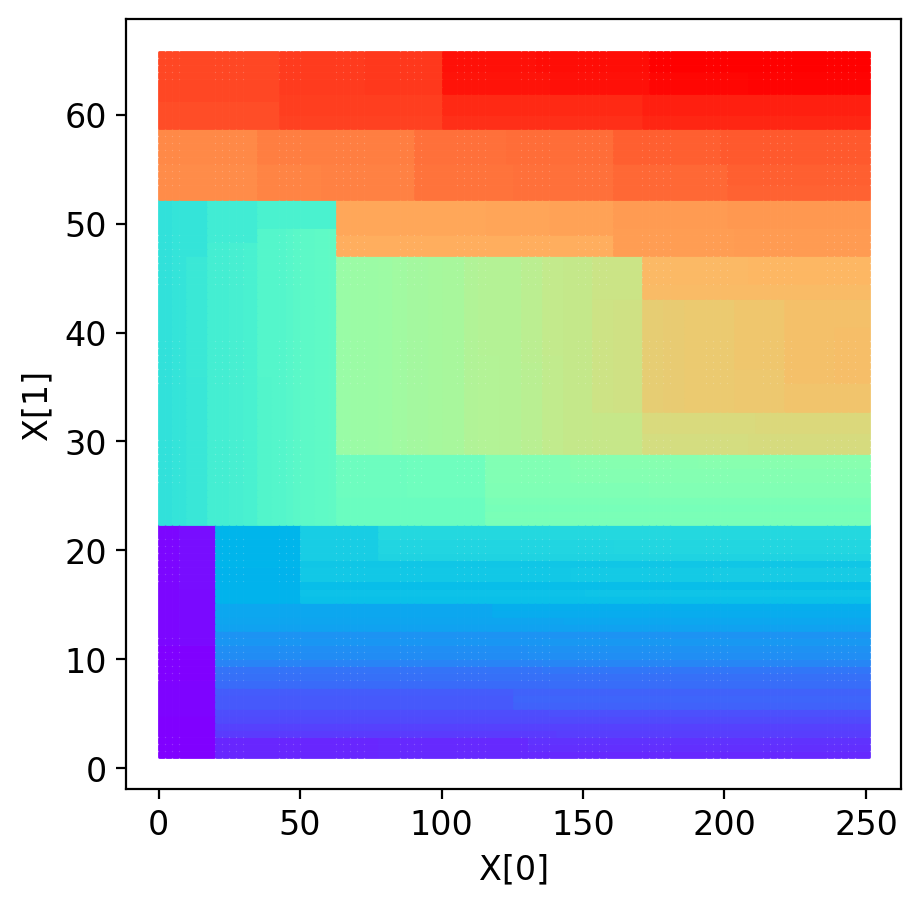

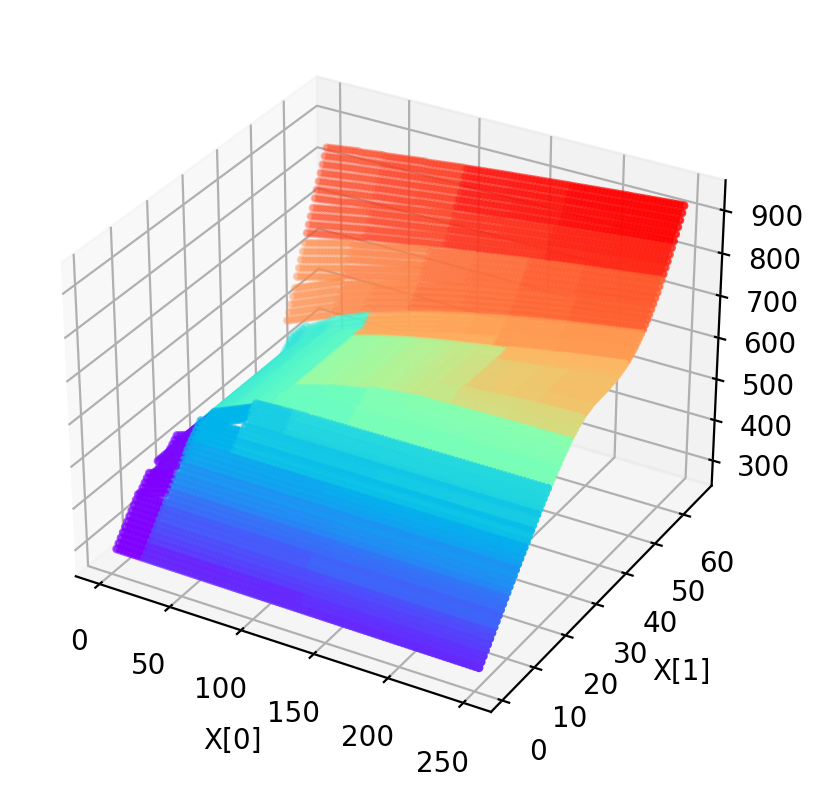

In [17]:
plot_surrogate_2d(model_ltr, features)

We can see the resemblance with the plot of the original data.

Now we will analyze if we can get a similarly good fit with a smaller tree by using the `HyperplaneTreeRegressor`.

### Hyperplane Tree Regressor

Using the default hyperparameters:

In [18]:
model_ht_1 = HyperplaneTreeRegressor()

t1 = time.time()
model_ht_1.fit(train_features, train_y)
t2 = time.time()

y_pred_ht_1 = model_ht_1.predict(test_features.to(torch_device)).cpu()

hyperplane_error = torch.mean(torch.abs(y_pred_ht_1 - test_y))
hyperplane_leaves = len(model_ht_1._leaves)
hyperplane_time = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Hyperplane Tree:       {hyperplane_leaves}            {hyperplane_error:.3f}          {hyperplane_time:.2f}')

  0%|          | 0/200.0 [00:00<?, ?it/s]

Model                  # Leaves      Error (MAE)    Training time (s)
Hyperplane Tree:       72            0.748          1.38


Hyperparameter sweep - `min_samples_leaf`

In [19]:
min_samples_leaf_vals = np.logspace(-4, -0.5, 10)
numbers_of_leaves = []
train_errors = []
test_errors = []

for min_samples_leaf in tqdm(min_samples_leaf_vals):
    model = HyperplaneTreeRegressor(
        min_samples_leaf = min_samples_leaf,
        disable_tqdm = True,
    )

    model.fit(train_features, train_y)
    
    numbers_of_leaves.append(model.num_leaves)

    y_pred = model.predict(features.to(torch_device)).cpu()

    train_errors.append(torch.mean(torch.abs(y_pred[train_indices] - y[train_indices])))
    test_errors.append(torch.mean(torch.abs(y_pred[test_indices] - y[test_indices])))

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/carolinacolombotedesco/Library/Python/3.9/lib/python/site-packages/systems2atoms/hyperplanetree/hyperplanetree/_classes.py:654: UserWarning: Training appears to have ended early.If the fit is insufficiently accurate, try increasing max_bins or max_weight.
  warnings.warn(


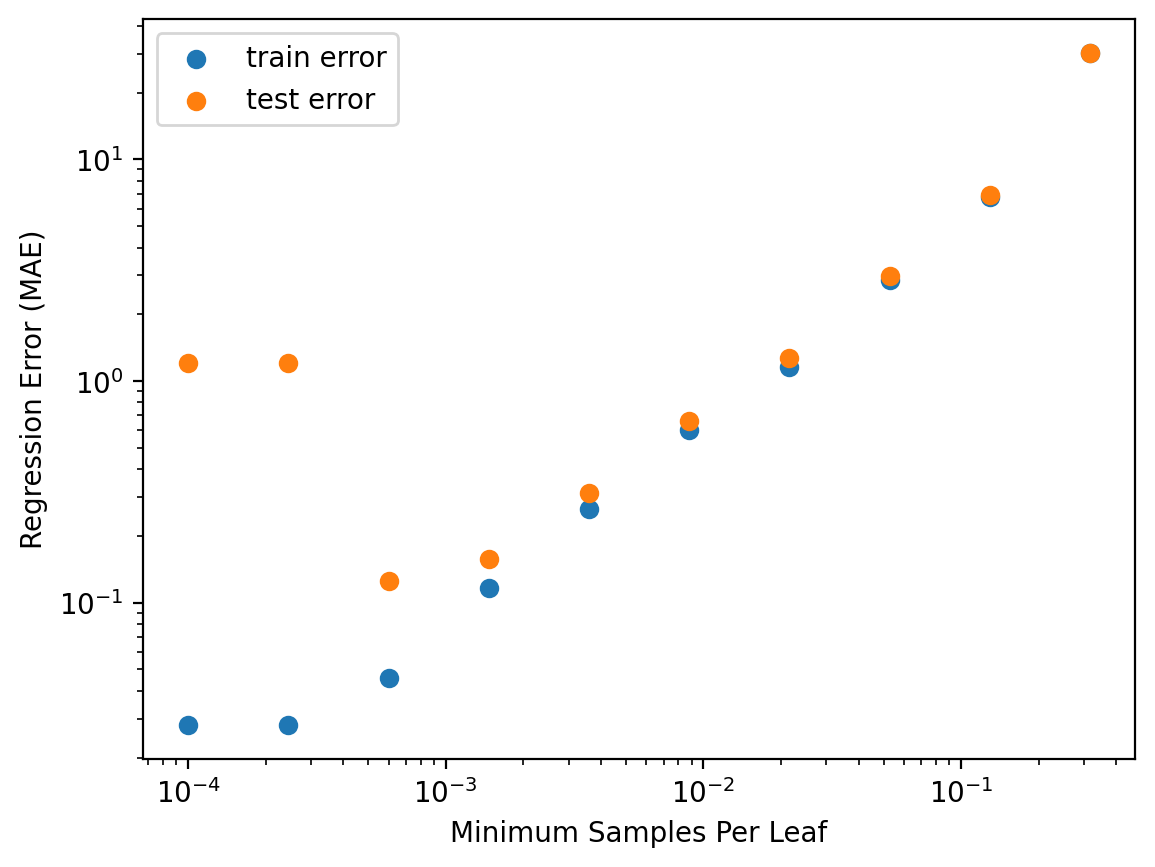

In [20]:
plt.scatter(min_samples_leaf_vals, train_errors, label = 'train error')
plt.scatter(min_samples_leaf_vals, test_errors, label = 'test error')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel('Minimum Samples Per Leaf')
plt.ylabel('Regression Error (MAE)')

plt.legend()

plt.show()

We see that for this regressor the overfitting occurs for a smaller tree than for the linear regressor, which is also an indication that smaller trees when using hyperplanetree already describe the data well. 

Still, one can see that once again `min_samples_leaf` ~ 0.006 results in a low MAE while not leading to overfitting.

### Evaluation after hyperparameter sweep

In [21]:
model_ht = HyperplaneTreeRegressor(
    min_samples_leaf = 0.006,
    disable_tqdm = True,
)

t1 = time.time()
model_ht.fit(train_features, train_y)
t2 = time.time()

y_pred_ht = model_ht.predict(test_features.to(torch_device)).cpu()

hyperplane_error = torch.mean(torch.abs(y_pred_ht - test_y))
hyperplane_leaves = len(model_ht._leaves)
hyperplane_time = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Hyperplane Tree:       {hyperplane_leaves}            {hyperplane_error:.3f}          {hyperplane_time:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Hyperplane Tree:       119            0.453          1.43


Note that the number of leaves is the same than for the LinearTree, since the hyperparameter that determines it the same, but the MAE is lower when using HyperplaneTree. The trade-off is with the training time.

Visualizing the splits - a feature of the package:

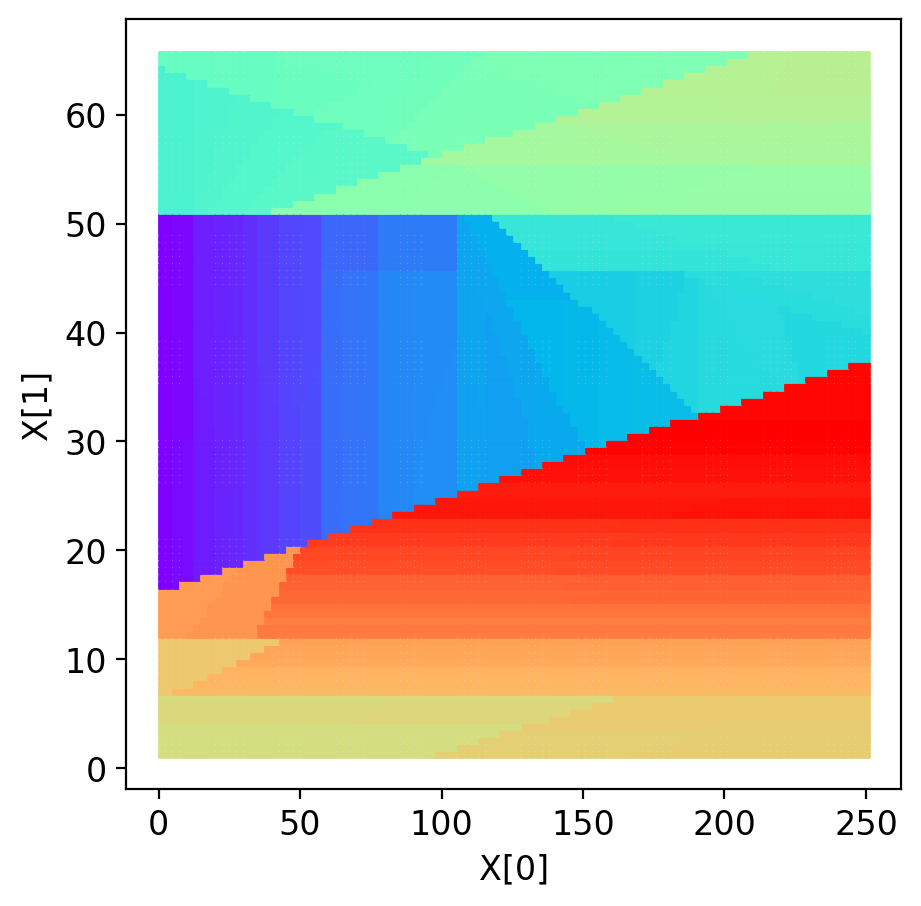

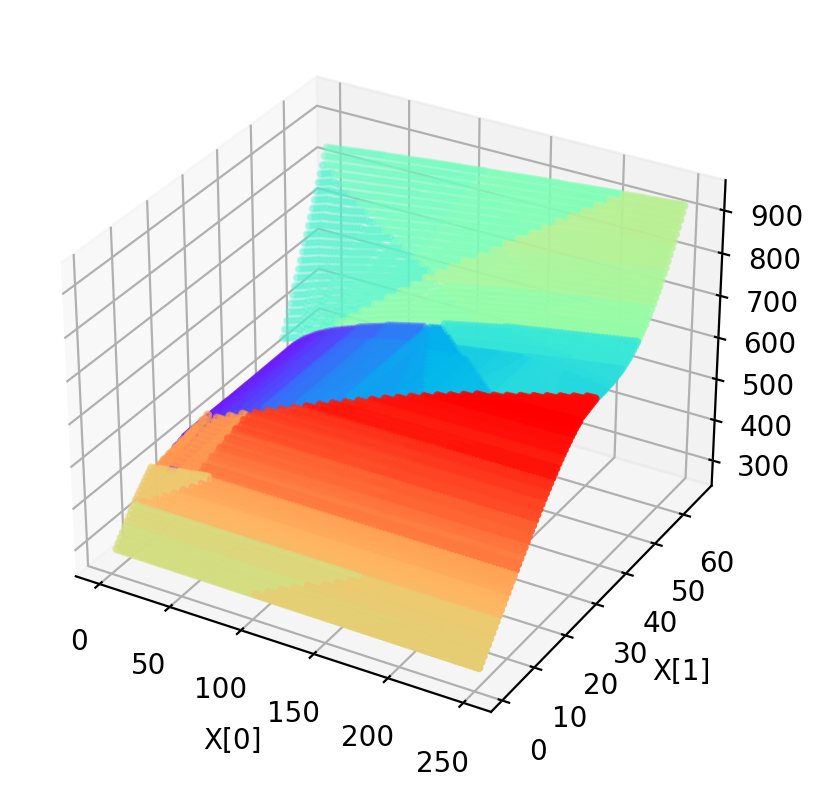

In [22]:
plot_surrogate_2d(model_ht, features)

The hyperplane tree in fact provides a visually better fit to the model than LMDT, as expected.

In [23]:
# print(HyperplaneTreeRegressor.__doc__)

## Regression comparisons

In [24]:
print(f'Model                  # Leaves      Error (MAE)    Training time (s)')

print(f'Decision Tree:         {num_leaves_dt}           {dt_error:.3f}          {dt_time:.2f}')
print(f'Linear Tree:           {linear_leaves}           {linear_error:.3f}          {linear_time:.2f}')
print(f'Hyperplane Tree:       {hyperplane_leaves}           {hyperplane_error:.3f}          {hyperplane_time:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Decision Tree:         469           1.961          0.01
Linear Tree:           181           0.521          0.51
Hyperplane Tree:       119           0.453          1.43


### Analyzing trees of similar sizes

Let's get a decision tree with around 119 leaves to compare with the other decision trees.

In [25]:
model_dt_119 = DecisionTreeRegressor(random_state=42,
ccp_alpha=0.01, 
# max_depth=15, 
min_samples_leaf=44, 
# min_samples_split= 15,
)

t1 = time.time()
model_dt_119.fit(train_features, train_y)
t2 = time.time()

y_pred = model_dt_119.predict(test_features)

dt_error_119 = mean_absolute_error(y_pred, test_y)

num_leaves_dt_119 = model_dt_119.get_n_leaves()
dt_time_119 = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Decision Tree:           {num_leaves_dt_119}            {dt_error_119:.3f}          {dt_time_119:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Decision Tree:           120            5.488          0.01


In [26]:
model_ltr_119 = LinearTreeRegressor(
    min_samples_leaf=0.0061,
    disable_tqdm = True,
)
                        
t1 = time.time()
model_ltr_119.fit(train_features, train_y) 
t2 = time.time()

# Getting predictions around the test set usinf the model just fitted
y_pred_ltr = model_ltr_119.predict(test_features.to(torch_device)).cpu() 

# Assessing the mean absolute error 
linear_error_119 = torch.mean(torch.abs(y_pred_ltr - test_y)) 

linear_leaves_119 = model_ltr_119.num_leaves
linear_time_119 = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Linear Tree:           {linear_leaves_119}            {linear_error_119:.3f}          {linear_time_119:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Linear Tree:           119            0.776          0.40


In [27]:
print(f'Model                  # Leaves      Error (MAE)    Training time (s)')

print(f'Decision Tree:         {num_leaves_dt_119}           {dt_error_119:.3f}          {dt_time_119:.2f}')
print(f'Linear Tree:           {linear_leaves_119}           {linear_error_119:.3f}          {linear_time_119:.2f}')
print(f'Hyperplane Tree:       {hyperplane_leaves}           {hyperplane_error:.3f}          {hyperplane_time:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Decision Tree:         120           5.488          0.01
Linear Tree:           119           0.776          0.40
Hyperplane Tree:       119           0.453          1.43


By this comparison, one can see the tradeoffs between number of leaves, MAE and training time between the methods. The hyperplane tree regressor was able to reach the lowest MAE, at the expense of a longer (though still short) training time.

### Pareto front

In [28]:
!pip install git+https://github.com/emsunshine/linear-tree@main
from lineartree import LinearTreeRegressor as OriginalLinearTreeRegressor

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/emsunshine/linear-tree (to revision main) to /private/var/folders/ly/14n5x27j4x58m15svpw3z2zm0000gn/T/pip-req-build-_my_w5sq
  Running command git clone --filter=blob:none --quiet https://github.com/emsunshine/linear-tree /private/var/folders/ly/14n5x27j4x58m15svpw3z2zm0000gn/T/pip-req-build-_my_w5sq
  Resolved https://github.com/emsunshine/linear-tree to commit f2c6a79fd72341cff1aed742723448e22dd0f0f6
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [29]:
min_samples_leaf_vals = np.logspace(np.log(3), np.log(len(train_y)/2.01), 20, base = np.e)
print([int(x) for x in min_samples_leaf_vals])

linear_num_leaves = []
linear_train_errors = []
linear_test_errors = []

hyperplane_num_leaves = []
hyperplane_train_errors = []
hyperplane_test_errors = []

original_num_leaves = []
original_train_errors = []
original_test_errors = []

decision_num_leaves = []
decision_train_errors = []
decision_test_errors = []

# Loop for DecisionTreeRegressor
for min_samples_leaf in tqdm(min_samples_leaf_vals):
    min_samples_leaf = int(min_samples_leaf)

    model = DecisionTreeRegressor(
        min_samples_leaf = min_samples_leaf,
    )

    model.fit(train_features, train_y)

    decision_num_leaves.append(model.get_n_leaves())
    y_pred = model.predict(features)
    decision_train_errors.append(torch.mean(torch.abs(torch.tensor(y_pred[train_indices]) - y[train_indices])))
    decision_test_errors.append(torch.mean(torch.abs(torch.tensor(y_pred[test_indices]) - y[test_indices])))

# Loop for OriginalLinearTreeRegressor
for min_samples_leaf in tqdm(min_samples_leaf_vals):
    min_samples_leaf = int(min_samples_leaf)

    model = OriginalLinearTreeRegressor(
        min_samples_leaf = min_samples_leaf,
        base_estimator = LinearRegression(),
        min_impurity_decrease = -np.inf,
        max_depth = 20,
        max_bins = 50,
    )

    model.fit(train_features, train_y)

    original_num_leaves.append(len(model._leaves))
    y_pred = model.predict(features)
    original_train_errors.append(torch.mean(torch.abs(torch.tensor(y_pred[train_indices]) - y[train_indices])))
    original_test_errors.append(torch.mean(torch.abs(torch.tensor(y_pred[test_indices]) - y[test_indices])))

# Loop for LinearTreeRegressor
for min_samples_leaf in tqdm(min_samples_leaf_vals):
    min_samples_leaf = int(min_samples_leaf)

    model = LinearTreeRegressor(
        min_samples_leaf = min_samples_leaf,
        max_bins = 50,
        disable_tqdm = True,
        min_impurity_decrease = -np.inf,
    )

    model.fit(train_features, train_y)

    linear_num_leaves.append(model.num_leaves)
    y_pred = model.predict(features.to(torch_device)).cpu()
    linear_train_errors.append(torch.mean(torch.abs(y_pred[train_indices] - y[train_indices])))
    linear_test_errors.append(torch.mean(torch.abs(y_pred[test_indices] - y[test_indices])))

# Loop for HyperplaneTreeRegressor
for min_samples_leaf in tqdm(min_samples_leaf_vals):
    min_samples_leaf = int(min_samples_leaf)

    model = HyperplaneTreeRegressor(
        min_samples_leaf = min_samples_leaf,
        max_bins = 50,
        disable_tqdm = True,
        min_impurity_decrease = -np.inf,
    )

    model.fit(train_features, train_y)

    hyperplane_num_leaves.append(model.num_leaves)
    y_pred = model.predict(features.to(torch_device)).cpu()
    hyperplane_train_errors.append(torch.mean(torch.abs(y_pred[train_indices] - y[train_indices])))
    hyperplane_test_errors.append(torch.mean(torch.abs(y_pred[test_indices] - y[test_indices])))

[3, 4, 6, 9, 13, 19, 29, 42, 61, 90, 132, 192, 281, 410, 599, 875, 1278, 1867, 2726, 3980]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Current number of nodes: 2033 | Current number of leaves: 2034
Current number of nodes: 1464 | Current number of leaves: 1465
Current number of nodes: 976 | Current number of leaves: 977
Current number of nodes: 641 | Current number of leaves: 642
Current number of nodes: 435 | Current number of leaves: 436
Current number of nodes: 306 | Current number of leaves: 307
Current number of nodes: 201 | Current number of leaves: 202
Current number of nodes: 133 | Current number of leaves: 134
Current number of nodes: 98 | Current number of leaves: 99
Current number of nodes: 60 | Current number of leaves: 61
Current number of nodes: 45 | Current number of leaves: 46
Current number of nodes: 29 | Current number of leaves: 30
Current number of nodes: 18 | Current number of leaves: 19
Current number of nodes: 15 | Current number of leaves: 16
Current number of nodes: 10 | Current number of leaves: 11
Current number of nodes: 6 | Current number of leaves: 7
Current number of nodes: 4 | Current n

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

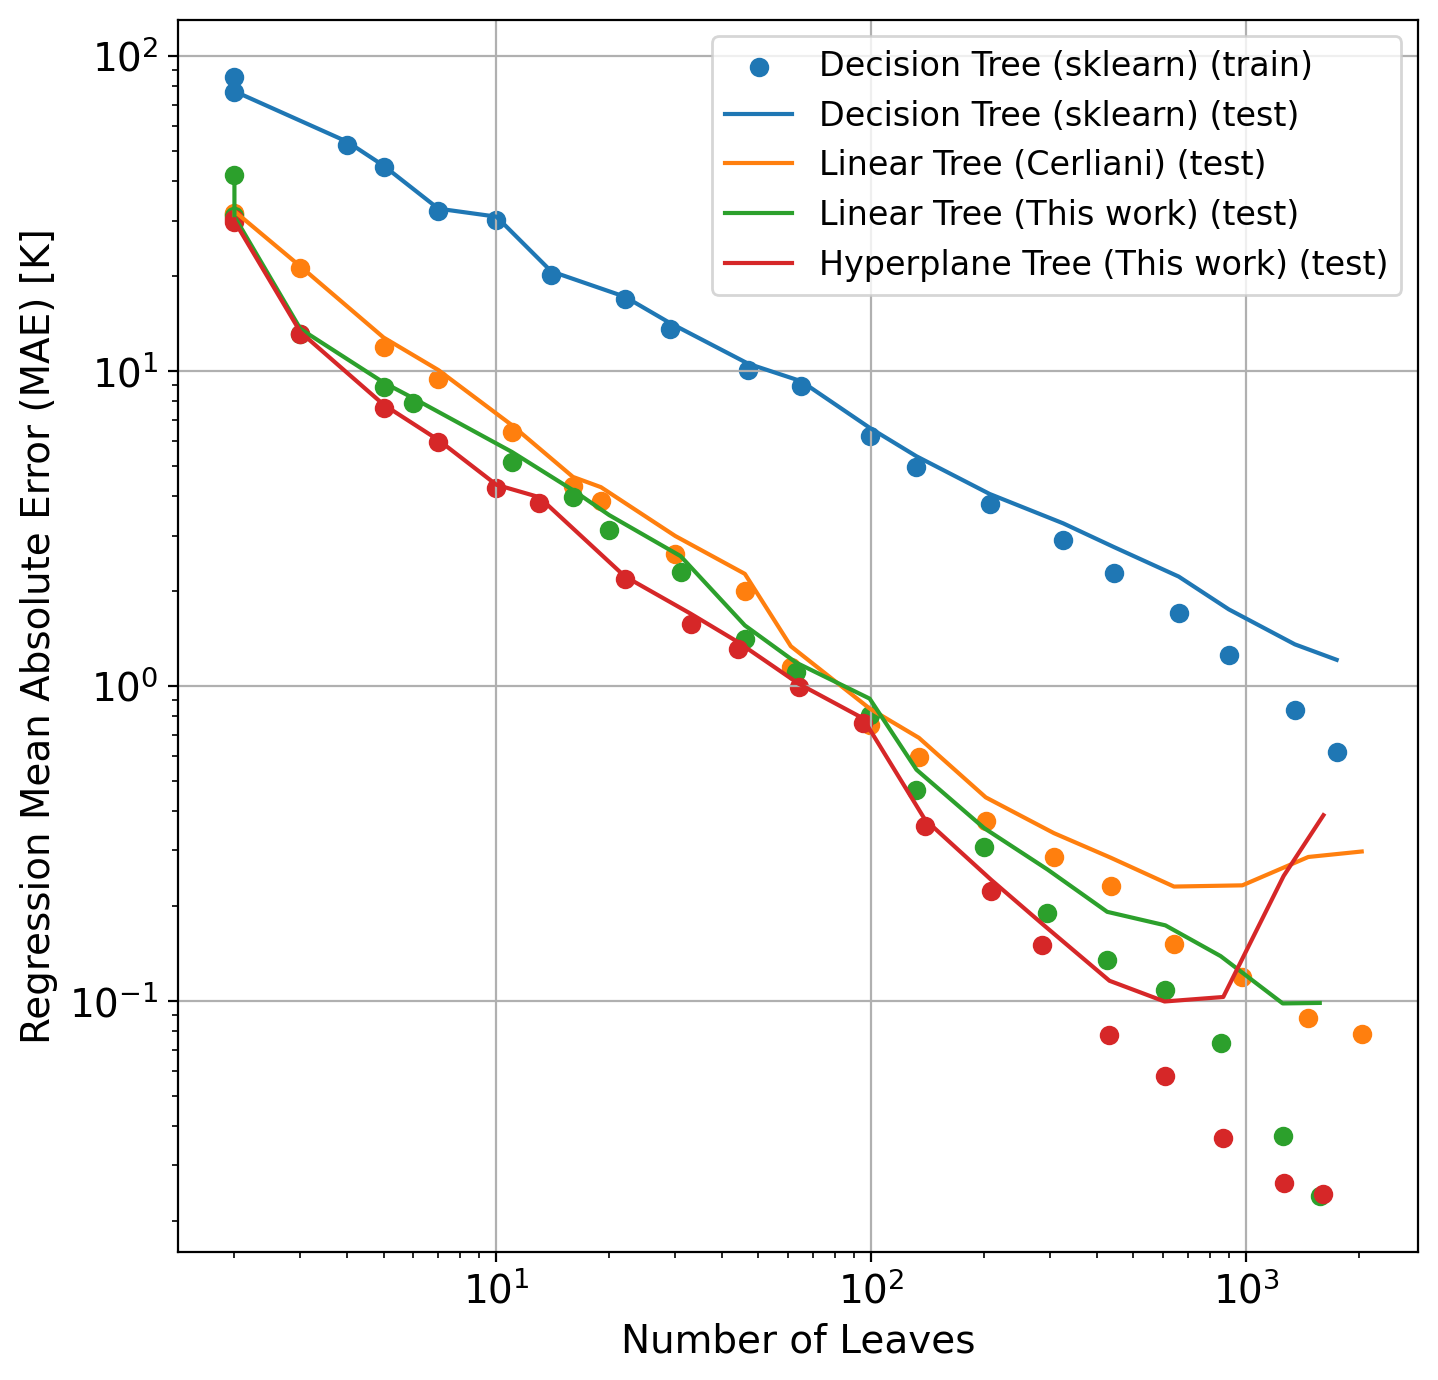

In [122]:
fig = plt.figure(figsize=(8,8))

plt.scatter(decision_num_leaves, decision_train_errors, label = 'Decision Tree (sklearn) (train)')
plt.plot(decision_num_leaves, decision_test_errors, label = 'Decision Tree (sklearn) (test)')

plt.scatter(original_num_leaves, original_train_errors)
plt.plot(original_num_leaves, original_test_errors, label = 'Linear Tree (Cerliani) (test)')


plt.scatter(linear_num_leaves, linear_train_errors)
plt.plot(linear_num_leaves, linear_test_errors, label = 'Linear Tree (This work) (test)')

plt.scatter(hyperplane_num_leaves, hyperplane_train_errors)
plt.plot(hyperplane_num_leaves, hyperplane_test_errors, label = 'Hyperplane Tree (This work) (test)')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.grid()

plt.xlabel('Number of Leaves', fontsize=14)
plt.ylabel('Regression Mean Absolute Error (MAE) [K]', fontsize=14)
plt.legend(fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)

plt.show()

fig.savefig("pareto_pht_ok.png", dpi=300, format='png')

## A direct comparison with the regression in Ammari (2023)

Here we try to reproduce and compare plots with the one shown in Ammari (2023) for this case, where each rectangle corresponds to a leaf.

Linear tree by Cerliani (2022), as used by Ammari (2023):

In [59]:
import lineartree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


model_ltr_ammari_cerliani = lineartree.LinearTreeRegressor(LinearRegression(), criterion="mae", min_samples_leaf=30, max_depth=6)

t1 = time.time()
model_ltr_ammari_cerliani.fit(train_features, train_y)
t2 = time.time()

# For evaluation, we will only use test data
y_pred = model_ltr_ammari_cerliani.predict(test_features)

# Evaluate the model
mae = mean_absolute_error(test_y, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")


Current number of nodes: 54 | Current number of leaves: 55
Mean Absolute Error (MAE): 1.1343


Linear tree within HyperplaneTree package:

In [108]:
from systems2atoms.hyperplanetree import LinearTreeRegressor, HyperplaneTreeRegressor, plot_surrogate_2d

model_ltr_ammari = LinearTreeRegressor(min_samples_leaf=0.0007)

t1 = time.time()
model_ltr_ammari.fit(train_features, train_y)
t2 = time.time()

# For evaluation, we will only use test data
y_pred = model_ltr_ammari.predict(test_features.to(torch_device)).cpu()

linear_error = torch.mean(torch.abs(y_pred - test_y))
linear_leaves = model_ltr_ammari.num_leaves
linear_time = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Linear Tree:           {linear_leaves}            {linear_error:.3f}          {linear_time:.2f}')

  0%|          | 0/1333.3333333333333 [00:00<?, ?it/s]

Model                  # Leaves      Error (MAE)    Training time (s)
Linear Tree:           851            0.137          1.18


In [109]:
def phase_diagram_plot(model):
    contour_point_density = 1000
    imshow_point_density = 1000

    # Define a new set of features for plotting, a linear spacing of the domain with high density
    plot_features = torch.tensor(np.meshgrid(np.linspace(pressure.min(), pressure.max(), contour_point_density), 
                                             np.linspace(enthalpy.min(), enthalpy.max(), contour_point_density))).T.reshape(-1, 2)
    label = model.apply(plot_features.to(torch_device))

    # Make a contour plot of the labels
    fig = plt.figure(figsize=(10, 7))

    for i in tqdm(np.unique(label)):
        plt.contour(
            plot_features[:, 1].reshape(contour_point_density, contour_point_density),
            plot_features[:, 0].reshape(contour_point_density, contour_point_density),
            (label == i).reshape(contour_point_density, contour_point_density),
            levels=[0.5],
            colors='black',
            linewidths=1,
        )

    # Plot the temperature predictions
    plot_features = torch.tensor(np.meshgrid(np.linspace(pressure.min(), pressure.max(), imshow_point_density), 
                                             np.linspace(enthalpy.min(), enthalpy.max(), imshow_point_density))).T.reshape(-1, 2)
    y_pred = model.predict(plot_features.to(torch_device))

    plt.imshow(
        y_pred.reshape(imshow_point_density, imshow_point_density),
        extent=[plot_features[:, 1].min(), plot_features[:, 1].max(), 
                plot_features[:, 0].min(), plot_features[:, 0].max()],
        origin='lower',
        aspect='auto',
        cmap='viridis'
    )

    # Add colorbar with enhanced label and ticks
    cbar = plt.colorbar()
    cbar.set_label('Predicted Temperature [K]', fontsize=16)  # Enlarge label font
    cbar.ax.tick_params(labelsize=14)  # Enlarge tick label font size

    plt.xlim([plot_features[:, 1].min(), plot_features[:, 1].max()])
    plt.ylim([plot_features[:, 0].min(), plot_features[:, 0].max()])

    plt.ylabel('Pressure [bar]', fontsize=14)
    plt.xlabel('Enthalpy [kJ/mol]', fontsize=14)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=10)

    # Annotate phase regions
    plt.text(8, 120, 'Liquid', color='black', fontsize=14, weight='bold',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    plt.text(57, 120, 'Vapor', color='black', fontsize=14, weight='bold',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    plt.text(28, 65, 'Vapor + Liquid', color='black', fontsize=14, weight='bold',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    # Set the molar mass of water (kg/mol)
    molar_mass = 0.018015

    # Define a range of pressures in MPa
    P = np.linspace(0.1, 22, 2000)  # Pressure from 0.1 MPa to critical pressure

    # Saturated vapor and liquid enthalpy lines
    hliq = [IAPWS97(P=p, x=0).h for p in P]  # Saturated liquid enthalpy (kJ/kg)
    hvap = [IAPWS97(P=p, x=1).h for p in P]  # Saturated vapor enthalpy (kJ/kg)

    # Convert to kJ/mol
    hliq = [h * molar_mass for h in hliq]
    hvap = [h * molar_mass for h in hvap]

    # Critical point
    critical = IAPWS97(T=647.096, P=22.064)
    h_critical = critical.h * molar_mass  # Critical point enthalpy in kJ/mol
    p_critical = critical.P  # Critical pressure in MPa

    # Plot the critical point
    # plt.plot(h_critical, p_critical * 10, 'ro', markersize=8, label='Critical Point')

    # Save the data points to variables or files
    saturated_liquid_points = np.column_stack((hliq, P))  # Combine enthalpy and pressure
    saturated_vapor_points = np.column_stack((hvap, P))  # Combine enthalpy and pressure

    # Plot the saturated lines
    plt.plot(hliq, P * 10, 'r-', linewidth=2, label='VLE')
    plt.plot(hvap, P * 10, 'r-', linewidth=2)

    # Add artificial lines to connect endpoints to the critical point
    plt.plot([hliq[-1], h_critical], [P[-1] * 10, p_critical * 10], 'r-', linewidth=2)  # Liquid to critical
    plt.plot([hvap[-1], h_critical], [P[-1] * 10, p_critical * 10], 'r-', linewidth=2)  # Vapor to critical

    plt.legend(fontsize=12)
    plt.show()

    return fig


  0%|          | 0/851 [00:00<?, ?it/s]

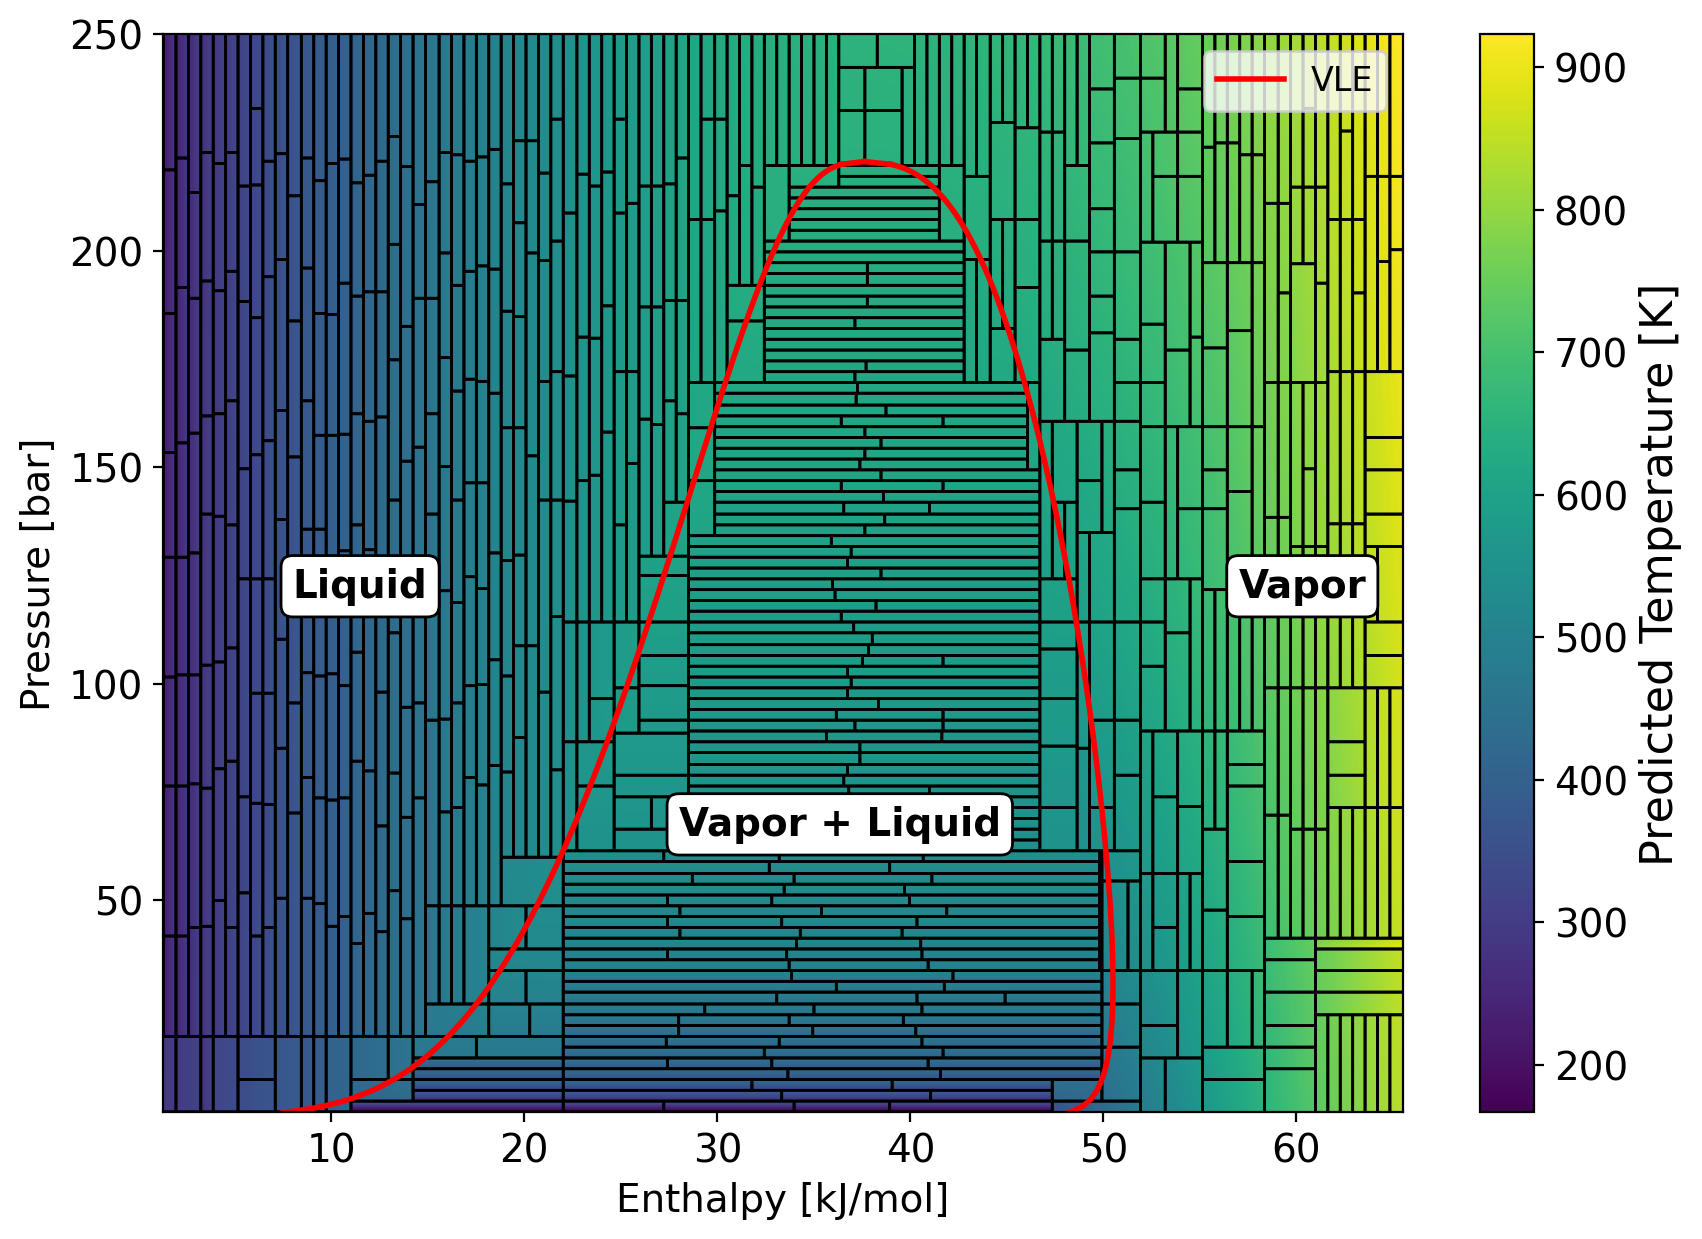

In [110]:
fig = phase_diagram_plot(model_ltr_ammari)

fig.savefig("linear_phase.png", dpi=300, format='png')

In [111]:
model_ht_more_leaves = HyperplaneTreeRegressor(
    min_samples_leaf = 0.001,
    disable_tqdm = True,
)

t1 = time.time()
model_ht_more_leaves.fit(train_features, train_y)
t2 = time.time()

y_pred_ht_more_leaves = model_ht_more_leaves.predict(test_features.to(torch_device)).cpu()

hyperplane_error_more_leaves = torch.mean(torch.abs(y_pred_ht_more_leaves - test_y))
hyperplane_leaves_more_leaves = len(model_ht_more_leaves._leaves)
hyperplane_time_more_leaves = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Hyperplane Tree:       {hyperplane_leaves_more_leaves}            {hyperplane_error_more_leaves:.3f}          {hyperplane_time_more_leaves:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Hyperplane Tree:       658            0.132          3.15


  0%|          | 0/658 [00:00<?, ?it/s]

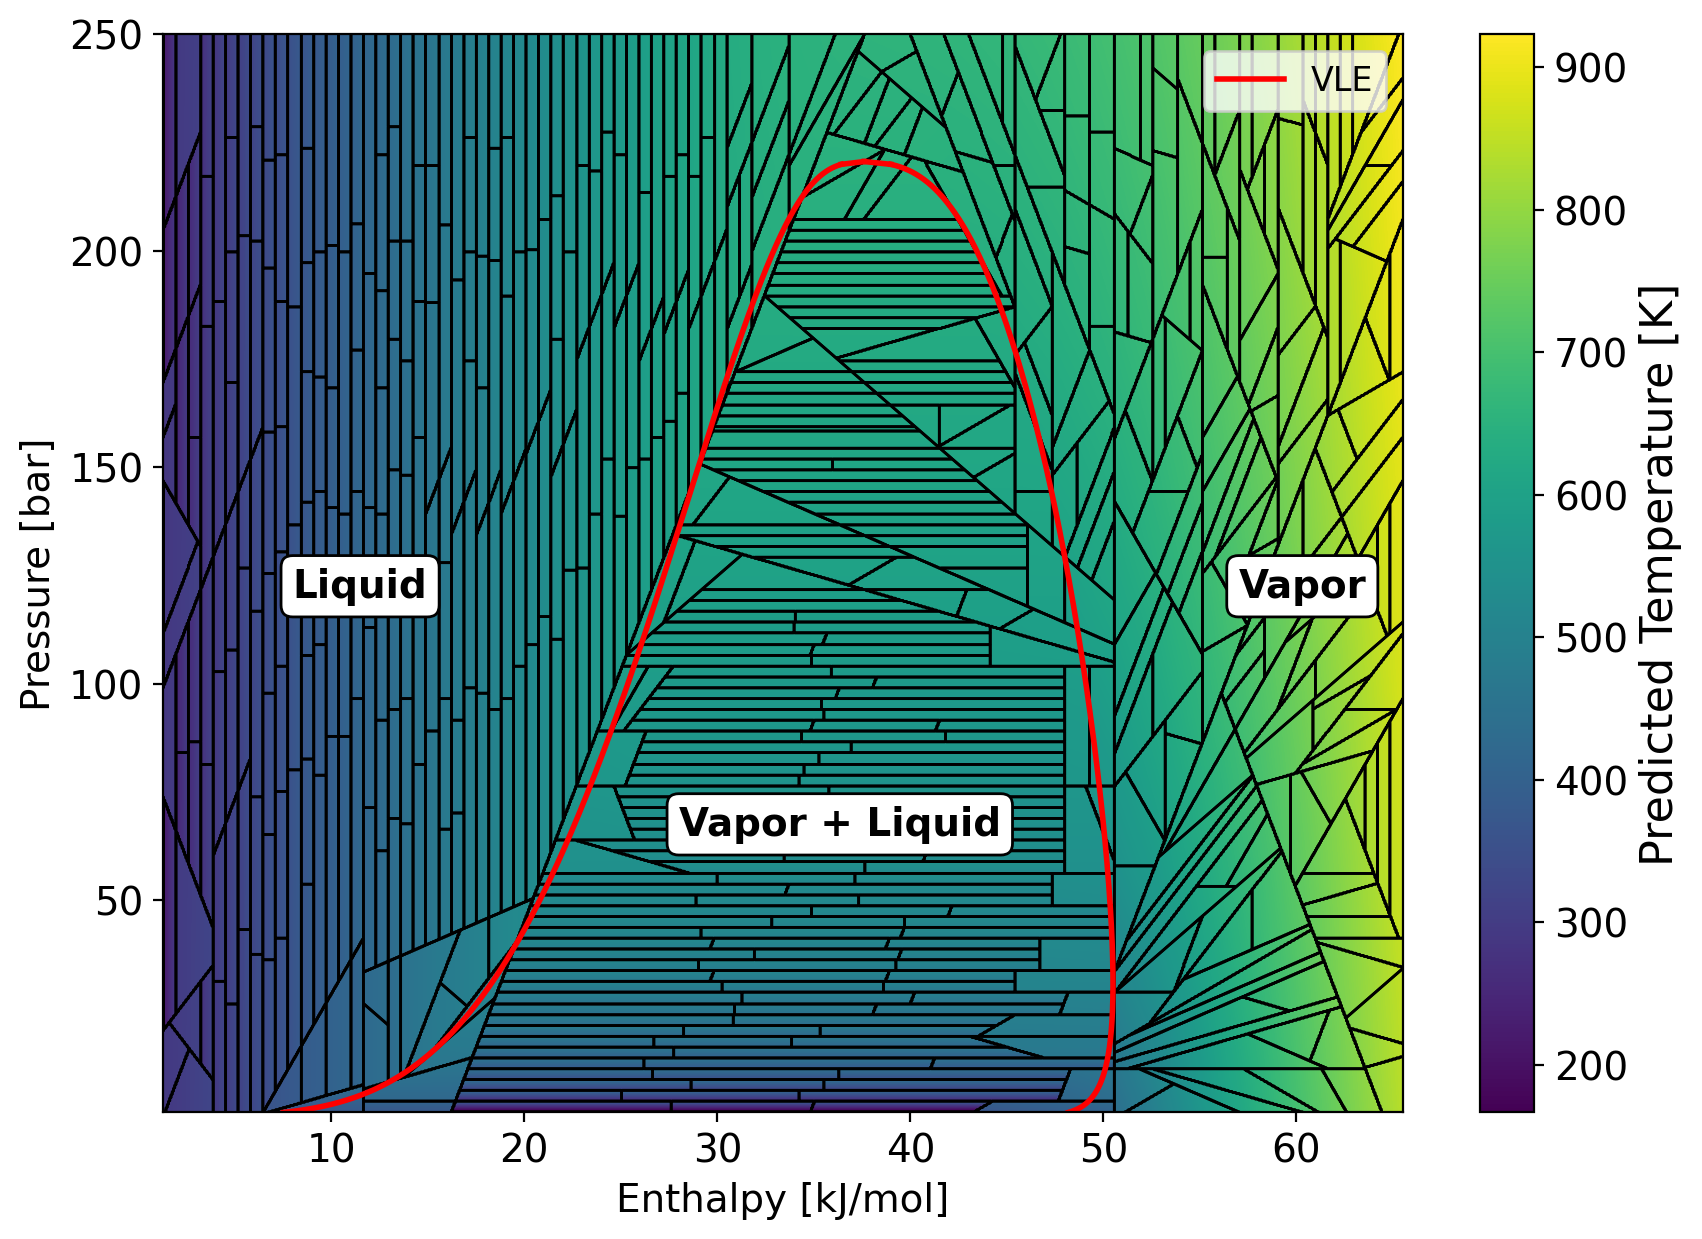

In [112]:
fig = phase_diagram_plot(model_ht_more_leaves)

fig.savefig("ht_more_leaves_phase.png", dpi=300, format='png')

In [113]:
model_ht_less_leaves = HyperplaneTreeRegressor(
    min_samples_leaf = 0.008,
    disable_tqdm = True,
)

t1 = time.time()
model_ht_less_leaves.fit(train_features, train_y)
t2 = time.time()

y_pred_ht_less_leaves = model_ht_less_leaves.predict(test_features.to(torch_device)).cpu()

hyperplane_error_less_leaves = torch.mean(torch.abs(y_pred_ht_less_leaves - test_y))
hyperplane_leaves_less_leaves = len(model_ht_less_leaves._leaves)
hyperplane_time_less_leaves= t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Hyperplane Tree:       {hyperplane_leaves_less_leaves}            {hyperplane_error_less_leaves:.3f}          {hyperplane_time_less_leaves:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Hyperplane Tree:       93            0.621          1.51


  0%|          | 0/93 [00:00<?, ?it/s]

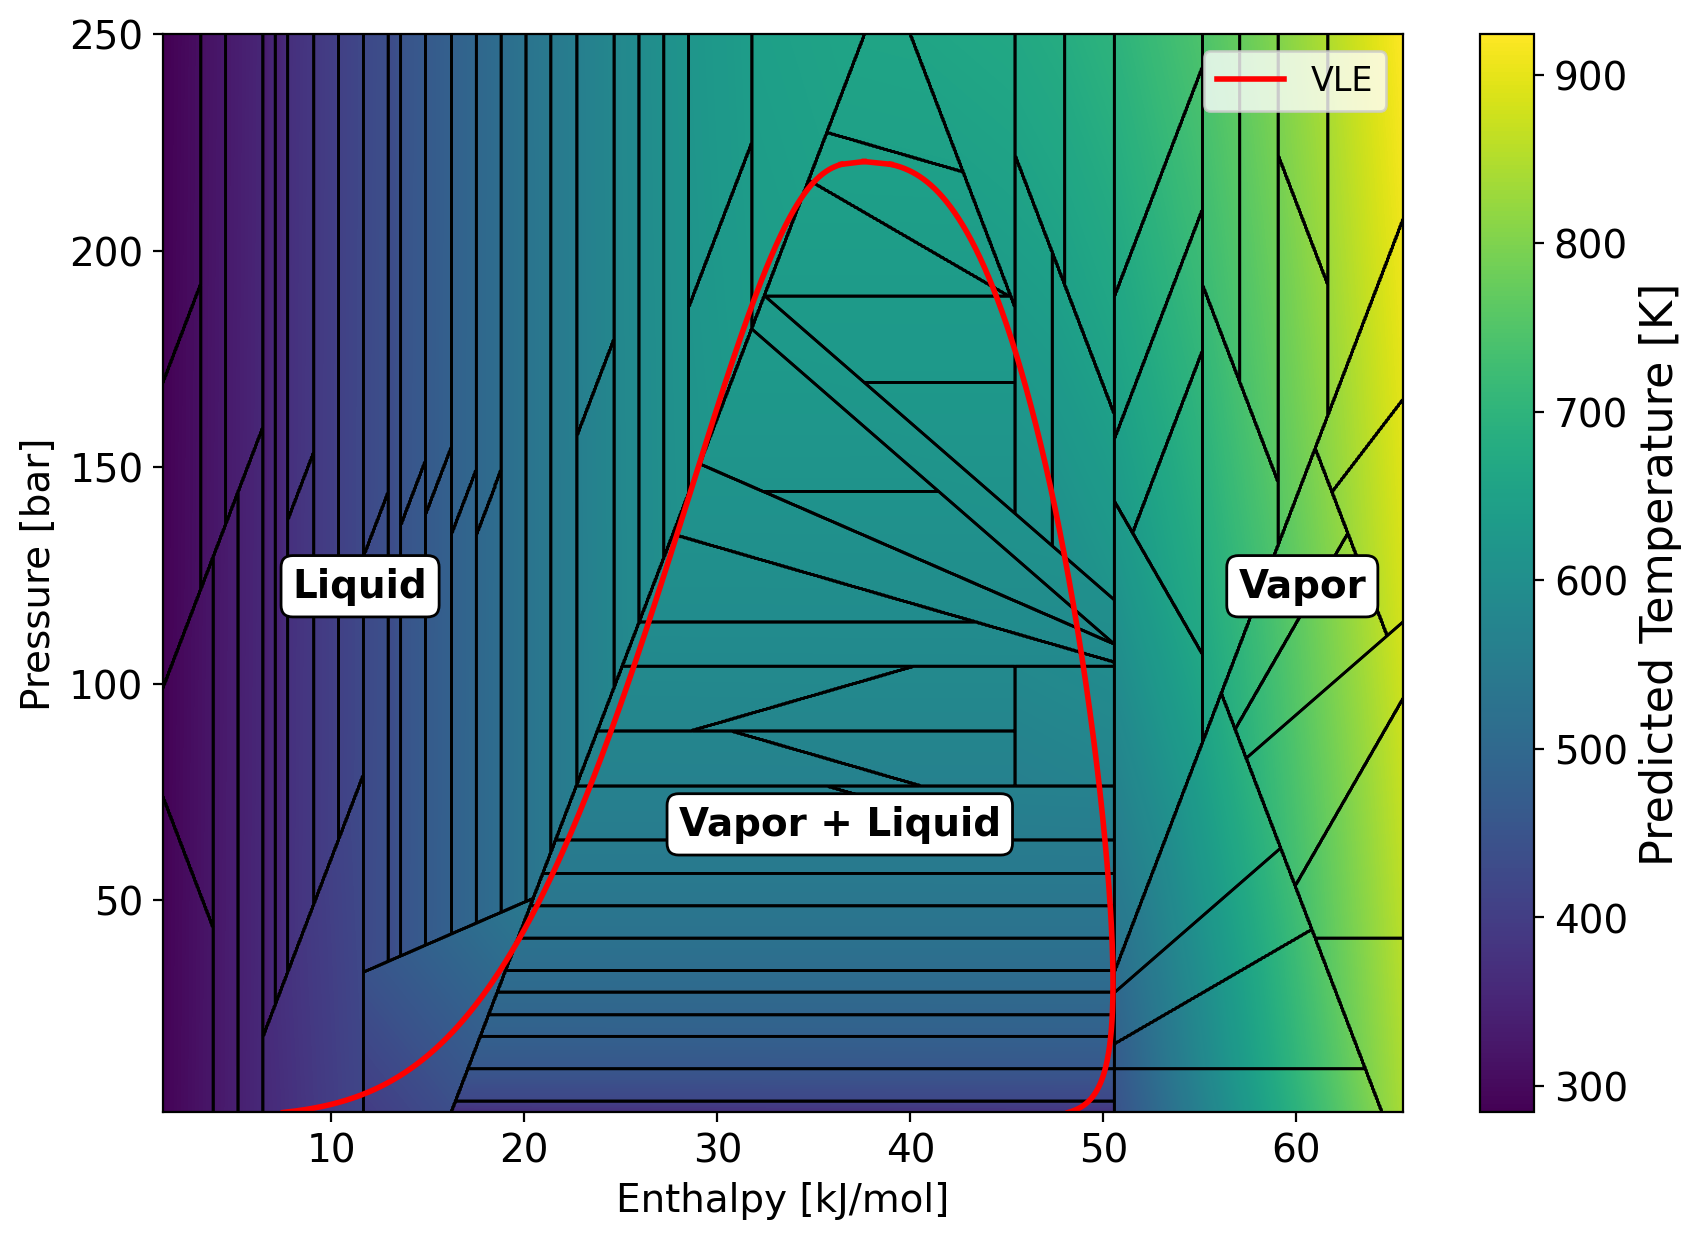

In [114]:
fig = phase_diagram_plot(model_ht_less_leaves)

fig.savefig("ht_less_leaves_phase.png", dpi=300, format='png')

For plots in which we can see the isotherms clearly:

In [115]:
model_ht_log = HyperplaneTreeRegressor(
    min_samples_leaf = 0.009,
    disable_tqdm = True,
)

t1 = time.time()
model_ht_log.fit(train_features, train_y)
t2 = time.time()

y_pred_ht = model_ht_log.predict(test_features.to(torch_device)).cpu()

hyperplane_error_log = torch.mean(torch.abs(y_pred_ht - test_y))
hyperplane_leaves_log = len(model_ht_log._leaves)
hyperplane_time_log = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Hyperplane Tree:       {hyperplane_leaves_log}            {hyperplane_error_log:.3f}          {hyperplane_time_log:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Hyperplane Tree:       78            0.659          1.37


Plotting for the surrogate:

In [116]:
model_ht_log = HyperplaneTreeRegressor(
    min_samples_leaf = 0.009,
    disable_tqdm = True,
)

t1 = time.time()
model_ht_log.fit(train_features, train_y)
t2 = time.time()

y_pred_ht = model_ht_log.predict(test_features.to(torch_device)).cpu()

hyperplane_error_log = torch.mean(torch.abs(y_pred_ht - test_y))
hyperplane_leaves_log = len(model_ht_log._leaves)
hyperplane_time_log = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Hyperplane Tree:       {hyperplane_leaves_log}            {hyperplane_error_log:.3f}          {hyperplane_time_log:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Hyperplane Tree:       78            0.659          1.01


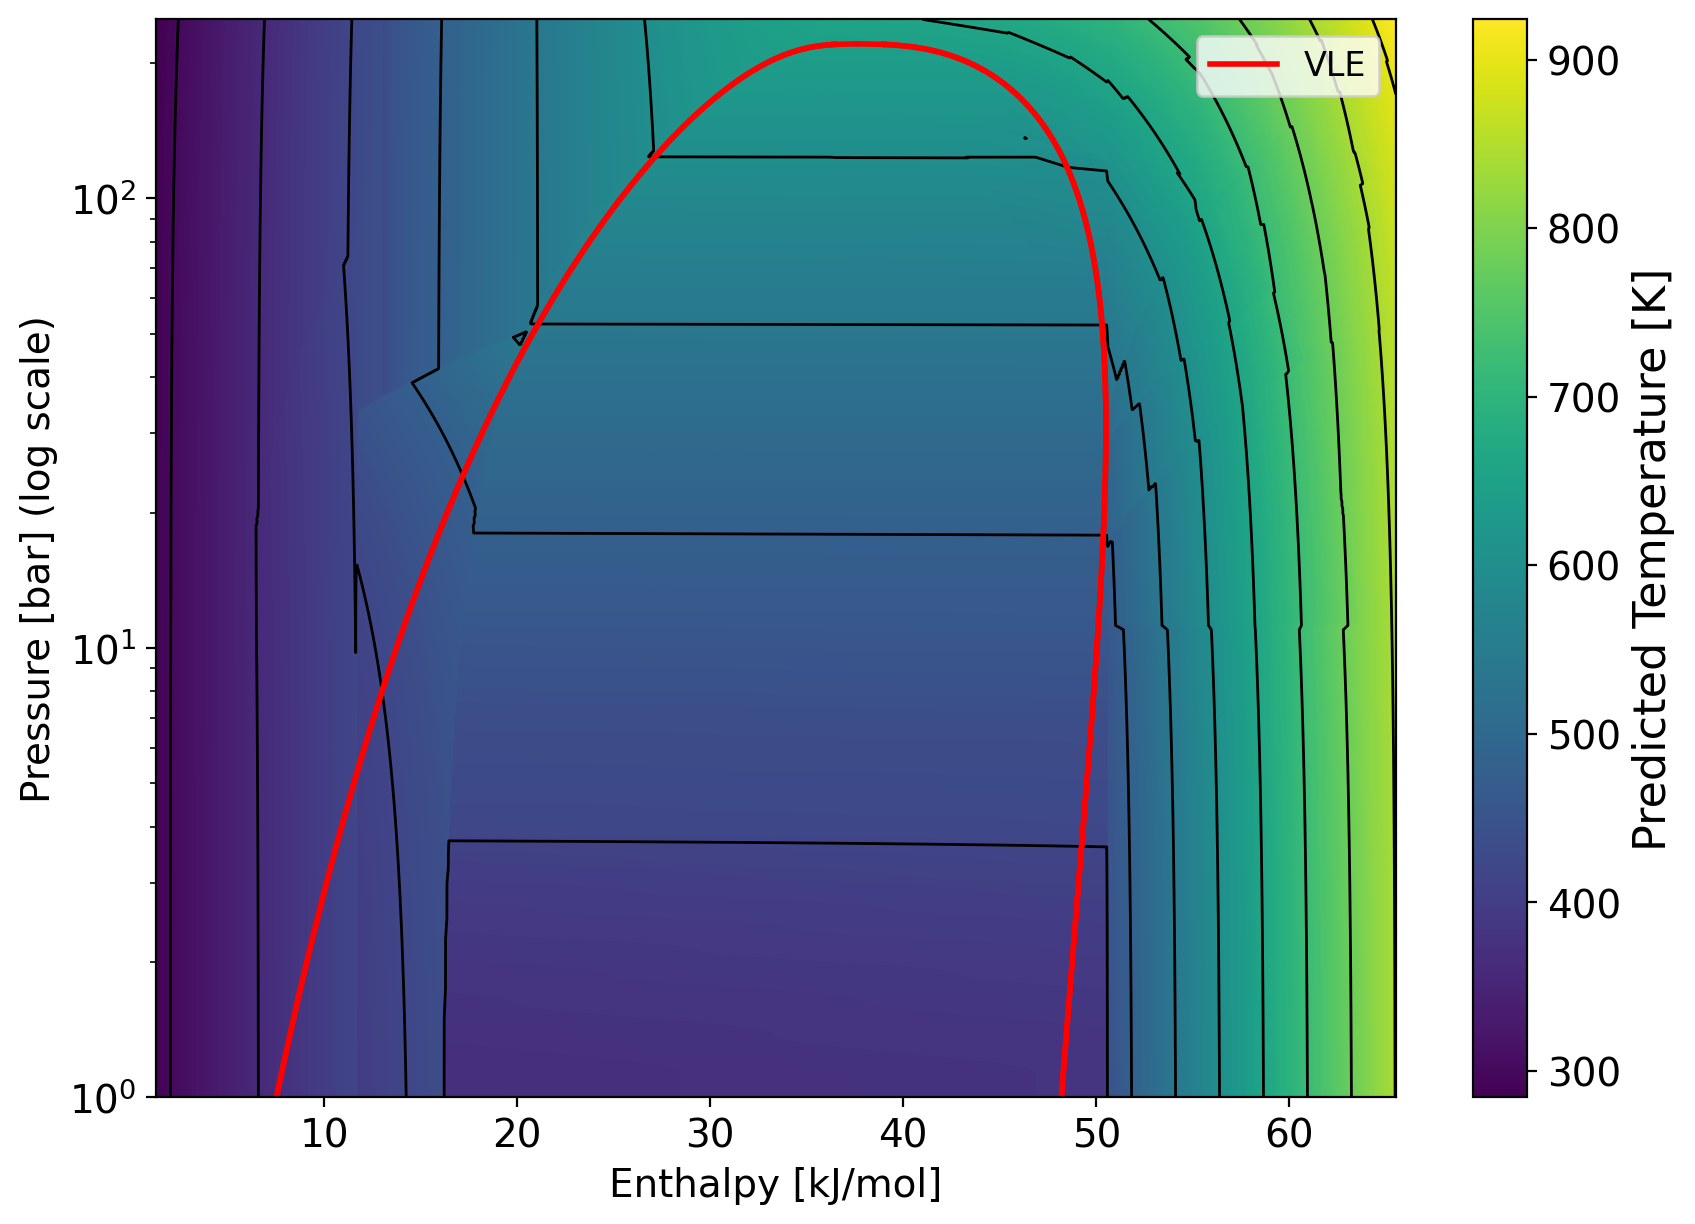

In [117]:
contour_point_density = 1000
imshow_point_density = 1000

plot_features = torch.tensor(np.meshgrid(
    np.linspace(pressure.min(), pressure.max(), contour_point_density),
    np.linspace(enthalpy.min(), enthalpy.max(), contour_point_density))
).T.reshape(-1, 2)

y_pred = model_ht_log.predict(plot_features.to(torch_device))

y_pred_reshaped = y_pred.reshape(contour_point_density, contour_point_density)

fig = plt.figure(figsize=(10, 7))

plt.contour(
    plot_features[:, 1].reshape(contour_point_density, contour_point_density),
    plot_features[:, 0].reshape(contour_point_density, contour_point_density),
    y_pred_reshaped,
    levels=10,  # Adjust the number of contour levels for temperature
    colors='black',
    linewidths=1,
)

plt.imshow(
    y_pred_reshaped,
    extent=[
        plot_features[:, 1].min(), plot_features[:, 1].max(),
        plot_features[:, 0].min(), plot_features[:, 0].max()
    ],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)

# Add colorbar with enhanced label and ticks
cbar = plt.colorbar()
cbar.set_label('Predicted Temperature [K]', fontsize=16)  # Enlarge label font
cbar.ax.tick_params(labelsize=14)  # Enlarge tick label font size

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)

    # Set the molar mass of water (kg/mol)
molar_mass = 0.018015

# Define a range of pressures in MPa
P = np.linspace(0.1, 22, 2000)  # Pressure from 0.1 MPa to critical pressure

# Saturated vapor and liquid enthalpy lines
hliq = [IAPWS97(P=p, x=0).h for p in P]  # Saturated liquid enthalpy (kJ/kg)
hvap = [IAPWS97(P=p, x=1).h for p in P]  # Saturated vapor enthalpy (kJ/kg)

# Convert to kJ/mol
hliq = [h * molar_mass for h in hliq]
hvap = [h * molar_mass for h in hvap]

# Save the data points to variables or files
saturated_liquid_points = np.column_stack((hliq, P))  # Combine enthalpy and pressure
saturated_vapor_points = np.column_stack((hvap, P))  # Combine enthalpy and pressure

plt.plot(hliq, P *10, 'r-', linewidth=2, label='VLE')
plt.plot(hvap, P *10, 'r-', linewidth=2)

# Critical point
critical = IAPWS97(T=647.096, P=22.064)
h_critical = critical.h * molar_mass  # Critical point enthalpy in kJ/mol
p_critical = critical.P  # Critical pressure in MPa

# Plot the critical point
# plt.plot(h_critical, p_critical * 10, 'ro', markersize=8, label='Critical Point')

# Save the data points to variables or files
saturated_liquid_points = np.column_stack((hliq, P))  # Combine enthalpy and pressure
saturated_vapor_points = np.column_stack((hvap, P))  # Combine enthalpy and pressure

# Plot the saturated lines
plt.plot(hliq, P * 10, 'r-', linewidth=2)
plt.plot(hvap, P * 10, 'r-', linewidth=2)

# Add artificial lines to connect endpoints to the critical point
plt.plot([hliq[-1], h_critical], [P[-1] * 10, p_critical * 10], 'r-', linewidth=2)  # Liquid to critical
plt.plot([hvap[-1], h_critical], [P[-1] * 10, p_critical * 10], 'r-', linewidth=2)  # Vapor to critical



plt.xlim([plot_features[:, 1].min(), plot_features[:, 1].max()])
plt.ylim([plot_features[:, 0].min(), plot_features[:, 0].max()])

plt.yscale('log')

plt.ylabel('Pressure [bar] (log scale)', fontsize=14)
plt.xlabel('Enthalpy [kJ/mol]', fontsize=14)

plt.legend(fontsize=12)
plt.show()


fig.savefig("log_phase_ht.png", dpi=300, format='png')

Plotting for the data:

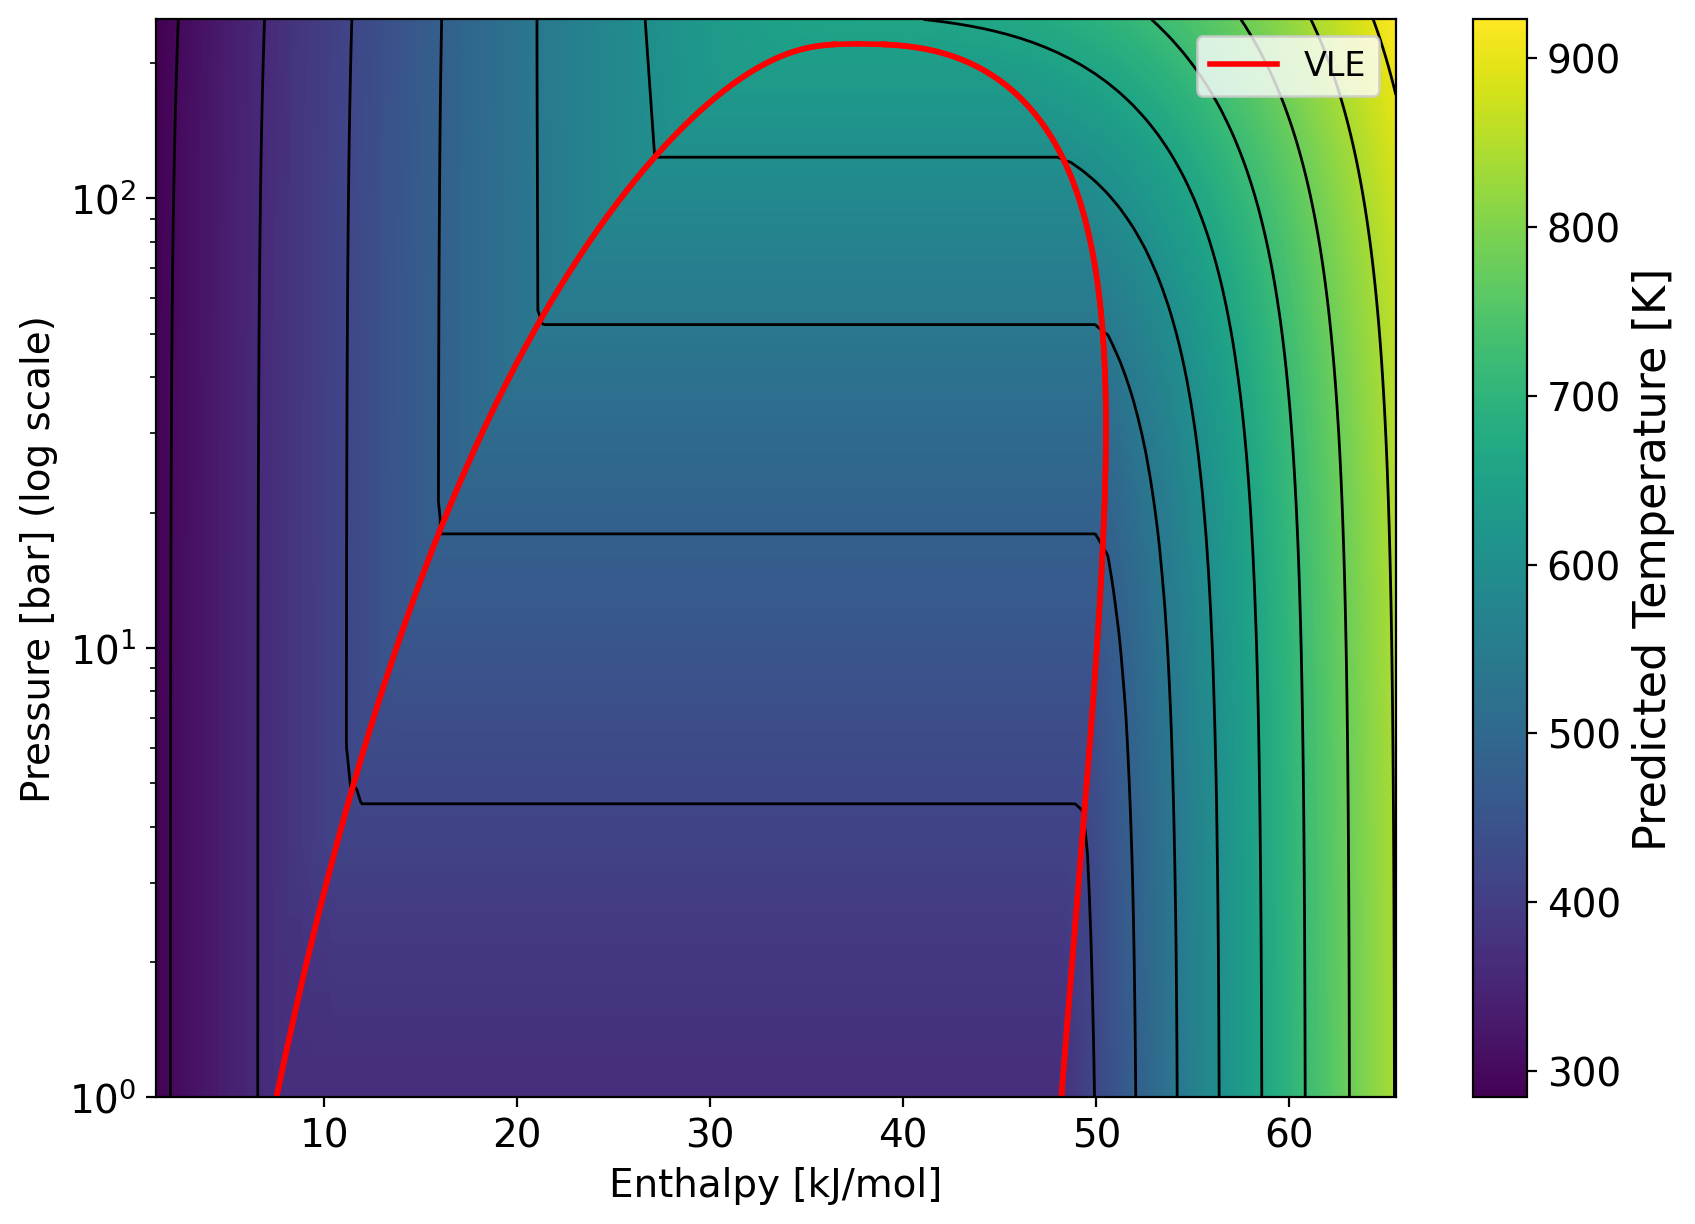

In [118]:
from scipy.interpolate import griddata

contour_point_density = 1000  # Match the contour_point_density in the provided function

# Create a dense grid for pressure and enthalpy
enthalpy_grid, pressure_grid = np.meshgrid(
    np.linspace(enthalpy.min(), enthalpy.max(), contour_point_density),
    np.linspace(pressure.min(), pressure.max(), contour_point_density)
)

# Interpolate the temperature data onto the dense grid
temperature_reshaped = griddata(
    (enthalpy, pressure),  # Original (x, y) points
    temperature,           # Values at those points
    (enthalpy_grid, pressure_grid),  # Target grid for interpolation
    method='linear'
)

# Plotting the interpolated data
fig = plt.figure(figsize=(10, 7))

# Plot temperature contours as black lines
plt.contour(
    enthalpy_grid,
    pressure_grid,
    temperature_reshaped,
    levels=10,  # Adjust the number of contour levels for temperature
    colors='black',
    linewidths=1
)

# Plot the temperature heatmap
plt.imshow(
    temperature_reshaped,
    extent=[
        enthalpy.min(), enthalpy.max(),
        pressure.min(), pressure.max()
    ],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)

# Add colorbar with enhanced label and ticks
cbar = plt.colorbar()
cbar.set_label('Predicted Temperature [K]', fontsize=16)  # Enlarge label font
cbar.ax.tick_params(labelsize=14)  # Enlarge tick label font size

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)

plt.xlim([enthalpy.min(), enthalpy.max()])
plt.ylim([pressure.min(), pressure.max()])

# Set logarithmic scale for the y-axis
plt.yscale('log')

plt.ylabel('Pressure [bar] (log scale)', fontsize=14)
plt.xlabel('Enthalpy [kJ/mol]', fontsize=14)

# Set the molar mass of water (kg/mol)
molar_mass = 0.018015

# Define a range of pressures in MPa
P = np.linspace(0.1, 22, 2000)  # Pressure from 0.1 MPa to critical pressure

# Saturated vapor and liquid enthalpy lines
hliq = [IAPWS97(P=p, x=0).h for p in P]  # Saturated liquid enthalpy (kJ/kg)
hvap = [IAPWS97(P=p, x=1).h for p in P]  # Saturated vapor enthalpy (kJ/kg)

# Convert to kJ/mol
hliq = [h * molar_mass for h in hliq]
hvap = [h * molar_mass for h in hvap]

# Save the data points to variables or files
saturated_liquid_points = np.column_stack((hliq, P))  # Combine enthalpy and pressure
saturated_vapor_points = np.column_stack((hvap, P))  # Combine enthalpy and pressure

# Critical point
critical = IAPWS97(T=647.096, P=22.064)
h_critical = critical.h * molar_mass  # Critical point enthalpy in kJ/mol
p_critical = critical.P  # Critical pressure in MPa

# Plot the critical point
# plt.plot(h_critical, p_critical * 10, 'ro', markersize=8, label='Critical Point')

# Save the data points to variables or files
saturated_liquid_points = np.column_stack((hliq, P))  # Combine enthalpy and pressure
saturated_vapor_points = np.column_stack((hvap, P))  # Combine enthalpy and pressure

# Plot the saturated lines
plt.plot(hliq, P * 10, 'r-', linewidth=2)
plt.plot(hvap, P * 10, 'r-', linewidth=2)

# Add artificial lines to connect endpoints to the critical point
plt.plot([hliq[-1], h_critical], [P[-1] * 10, p_critical * 10], 'r-', linewidth=2)  # Liquid to critical
plt.plot([hvap[-1], h_critical], [P[-1] * 10, p_critical * 10], 'r-', linewidth=2)  # Vapor to critical

plt.plot(hliq, P *10, 'r-', linewidth=2, label='VLE')
plt.plot(hvap, P *10, 'r-', linewidth=2)

# make y log
plt.yscale('log')
plt.legend(fontsize=12)
plt.show()

fig.savefig("log_phase_data.png", dpi=300, format='png')
